In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## LOADING LIBRARIES AND IMAGE FILES

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import time

In [72]:
df=pd.read_csv('/kaggle/input/facexpressions/data.csv')

In [73]:
exprss_labels = df['label'].value_counts()
exprss_labels

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

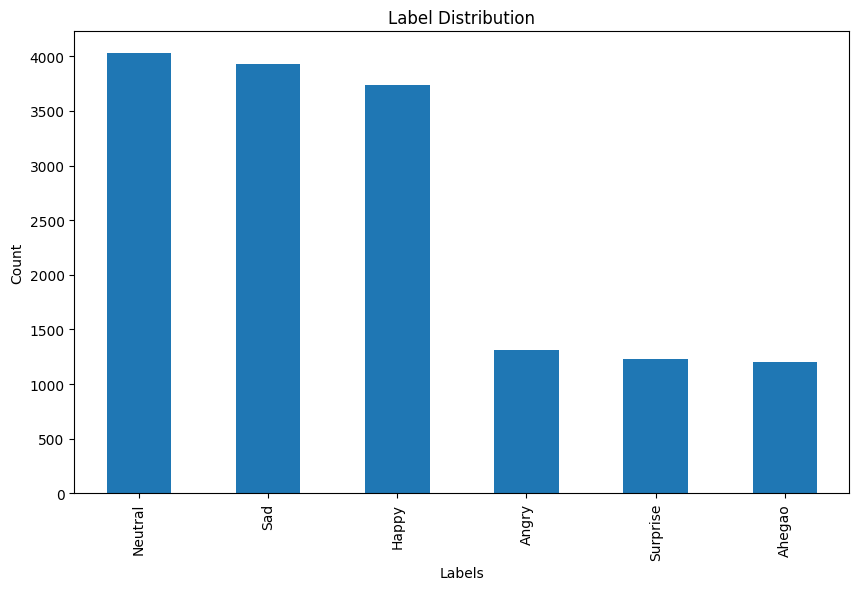

In [271]:
plt.figure(figsize=(10, 6))
exprss_labels.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [74]:
image_path ='/kaggle/input/facexpressions/dataset'

## Gaussian Blur, Histogram Equalization and Intensity thresholds

## IMAGE PREPROCESSING

In [75]:
train_df, val_df = tts(df, test_size=0.2, random_state=42, stratify=df['label'])

In [106]:
_,test_df = tts(val_df, test_size=0.5, random_state=42, stratify=val_df['label'])

In [171]:
# Custom preprocessing functions
#def gaussian_blur(img):
   # blurred_img = cv2.GaussianBlur(img, (5, 5), 0)  # Adjust kernel size as needed
    #return blurred_img

In [172]:
#def histogram_equalization(img):
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    #return img_output

In [173]:
#def intensity_threshold(img):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   # _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
   # return thresh

In [77]:
#Image Augumentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply shear transformation with a maximum shear intensity of 20%
    zoom_range=0.2,  # Zoom in or out of images by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',# Fill in missing pixels after transformations with the nearest value
    #preprocessing_function=gaussian_blur,  # Apply Gaussian Blur
    #preprocessing_function=histogram_equalization,  # Apply Histogram Equalization
    #preprocessing_function=intensity_threshold,  # Apply Intensity Thresholds
    #validation_split=0.3
)

In [95]:
#Loading and augmenting images
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_path,
    x_col='path',
    y_col='label',
    target_size=(64, 64),  # Resize images to 150x150 pixels
    batch_size=64,
    class_mode='categorical',# Assuming binary classification task
    subset='training',
    shuffle=True
)

Found 12362 validated image filenames belonging to 6 classes.


In [96]:
#Data validation without augmentation
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator= validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_path,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical'
)

Found 3091 validated image filenames belonging to 6 classes.


In [53]:
len(validation_generator)

97

## MODEL BUILDING

In [97]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPool2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(0.2),    

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [98]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,486 (4.87 MB)

 Trainable params: 1,275,590 (4.87 MB)

 Non-trainable params: 896 (3.50 KB)

## MODEL COMPILING AND FITTING

In [99]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
# Fit the model
history= model.fit(
    train_generator,
    #steps_per_epoch=len(train_df) // 32,
    epochs=2,
    validation_data=validation_generator,
    #validation_steps=len(val_df) // 32
)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 112s 548ms/step - accuracy: 0.2514 - loss: 2.1031 - val_accuracy: 0.2633 - val_loss: 1.7107
Epoch 2/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 143s 554ms/step - accuracy: 0.3254 - loss: 1.6260 - val_accuracy: 0.3581 - val_loss: 1.5711
Epoch 3/3
194/194 ━━━━━━━━━━━━━━━━━━━━ 109s 545ms/step - accuracy: 0.3756 - loss: 1.5167 - val_accuracy: 0.3921 - val_loss: 1.4562


In [107]:
#Data validation without augmentation
test_generator= validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_path,
    x_col='path',
    y_col='label',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1546 validated image filenames belonging to 6 classes.


## 	Training Time?
AUC and Confusion Matrix Computed	Done/Not Done
Overfitting/Underfitting checked and handled

In [114]:
y_preds = model.predict(test_generator)
y_preds_cls = np.argmax(y_preds, axis=1)
tcls = test_generator.classes
ls = list(test_generator.class_indices.keys())
len_ls = len(ls)
lbs = label_binarize(tcls, classes=np.arange(len_ls))
print(classification_report(tcls, y_preds_cls, target_names=ls))

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step
              precision    recall  f1-score   support

      Ahegao       0.54      0.52      0.53       120
       Angry       0.46      0.05      0.08       132
       Happy       0.72      0.12      0.21       374
     Neutral       0.36      0.53      0.43       403
         Sad       0.37      0.48      0.42       394
    Surprise       0.24      0.48      0.32       123

    accuracy                           0.37      1546
   macro avg       0.45      0.36      0.33      1546
weighted avg       0.46      0.37      0.34      1546



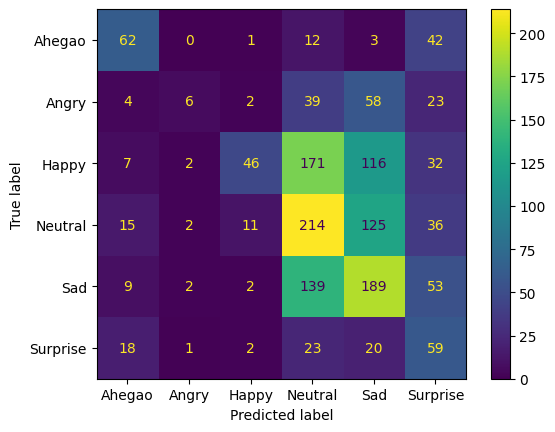

In [116]:
cm= confusion_matrix(tcls, y_preds_cls)
ConfusionMatrixDisplay(cm, display_labels=ls).plot()
plt.show()

In [117]:
print("AUC ROC Score:", roc_auc_score(lbs, y_preds, multi_class='ovr'))

AUC ROC Score: 0.7678245189020444


In [118]:
# Calculating the training time
start_time = time.time()
end_time = time.time()
training_time = end_time - start_time
print("Training time is :", training_time, "seconds")

Training time is : 2.8848648071289062e-05 seconds


##  Interpretability Implemented	Major Findings 

1st Round of Tuning	Issue Faced/Fixed
 	 2nd Round of Tuning